In [1]:
import pandas as pd
import os.path
import importlib
import plots as pl

In [2]:
importlib.reload(pl)

<module 'plots' from 'c:\\Software\\SynologyDrive\\Master Thesis\\deltaSVM-master\\plots.py'>

In [3]:
def calc_results(folder,tfs):
    results = pd.DataFrame(columns=["snp","tf","allele1_bind","allele2_bind","seq_binding","deltaSVM_score","preferred_allele"])
    for tf in tfs:
        if os.path.isfile(folder+"/out/summary_" + tf + ".pred.tsv"):
            results = results.append(pd.read_csv(folder+"/out/summary_" + tf + ".pred.tsv",sep='\t'), sort=False)
    results = results.rename(columns={"tf": "TF"})
    return results


In [4]:
def eval(file,folder):
    data = pd.read_csv(file)
    tfs = data["TF"].unique()
    results = calc_results(folder,tfs)
    data_com = data.merge(results, how='inner', on=["TF","snp"])
    pl.his_plot(data_com["pbs"],data_com["deltaSVM_score"])

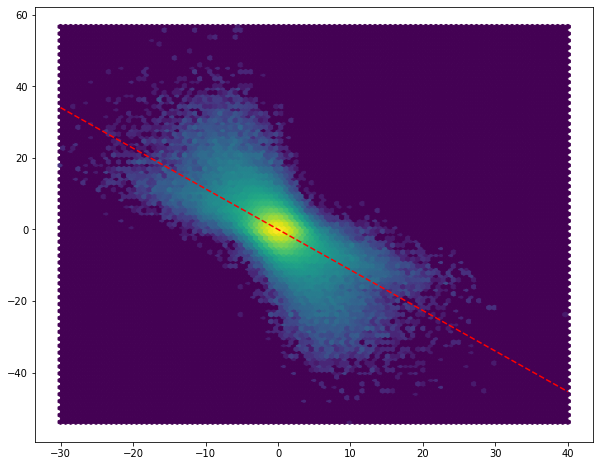

In [6]:
eval("old_batch.csv","old_batch")

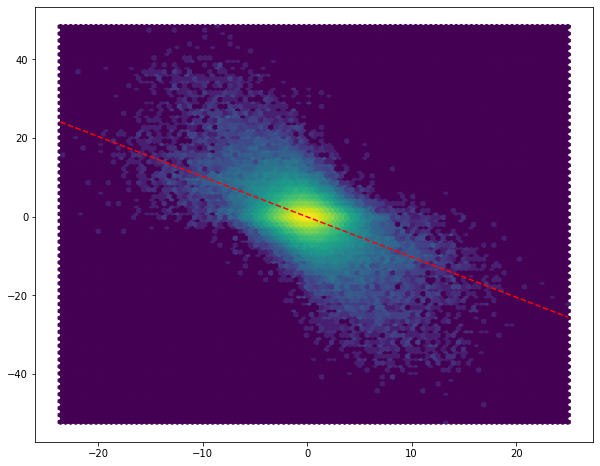

In [7]:
eval("GVATdb.novel_batch.csv","novel_batch")

In [5]:
#pbSNPs (P < 0.01) = True and non-pbSNPs (P > 0.5) = False
#AUPRC
#AUROC
#fivefold cross-validation.

from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [219]:
def calc_auc(data,col1,col2):
    return roc_auc_score(data[col1],data[col2])

In [229]:
def calc_prc(data,col1,col2):
    fpr,tpr,_ = precision_recall_curve(data[col1],data[col2])
    return auc(fpr,tpr)

In [186]:
def get_eval_data(file,folder):
    data = pd.read_csv(file)
    #True pbSNP
    data["pbSNP"] = data["pval"]<0.01

    res = calc_results(folder,data["TF"].unique())
    data = data.merge(res, how='inner', on=["TF","snp"])
    #data = data.drop(columns=["experiment","oligo","rsid","oligo_auc","ref","alt","ref_auc","alt_auc","snp"])

    #Loss, Gain, None
    data["gain"] = data["preferred_allele"]=="Gain"
    data["loss"] = data["preferred_allele"]=="Loss"
    data["none"] = data["preferred_allele"]=="None"
    #Y,N
    data["Y"] = data["seq_binding"]=="Y"
    data["N"] = data["seq_binding"]=="N"

    #Only (P < 0.01) = True and non-pbSNPs (P > 0.5) = False
    data = data[(data["pval"]<0.01) | (data["pval"]>0.5)]
    return data

In [193]:
def eval_auc(data,true_label):

    auc_gain = []
    auc_loss = []
    auc_none = []
    auc_y = []
    auc_n = []

    for tf in data["TF"].unique():
        auc_gain.append(calc_auc(data[data["TF"]==tf],true_label,"gain"))
        auc_loss.append(calc_auc(data[data["TF"]==tf],true_label,"loss"))
        auc_none.append(calc_auc(data[data["TF"]==tf],true_label,"none"))
        auc_y.append(calc_auc(data[data["TF"]==tf],true_label,"Y"))
        auc_n.append(calc_auc(data[data["TF"]==tf],true_label,"N"))

    plt.boxplot([auc_gain,auc_loss,auc_none,auc_y,auc_n],labels=["gain","loss","none","Y","N"])
    plt.show()
    #return data

In [232]:
def eval_prc(data,true_label):
    
    auc_gain = []
    auc_loss = []
    auc_none = []
    auc_y = []
    auc_n = []

    for tf in data["TF"].unique():
        auc_gain.append(calc_prc(data[data["TF"]==tf],true_label,"gain"))
        auc_loss.append(calc_prc(data[data["TF"]==tf],true_label,"loss"))
        #auc_none.append(calc_prc(data[data["TF"]==tf],true_label,"none"))
        auc_y.append(calc_prc(data[data["TF"]==tf],true_label,"Y"))
        #auc_n.append(calc_prc(data[data["TF"]==tf],true_label,"N"))

    plt.boxplot([auc_gain,auc_loss,auc_none,auc_y,auc_n],labels=["gain","loss","none","Y","N"])
    plt.show()
    #return data

In [189]:
old = get_eval_data("old_batch.csv","old_batch")

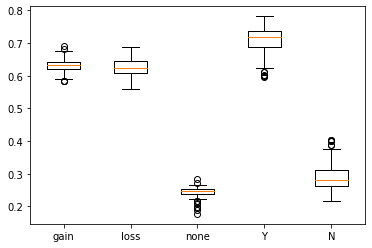

In [220]:
eval_auc(old,"pbSNP")

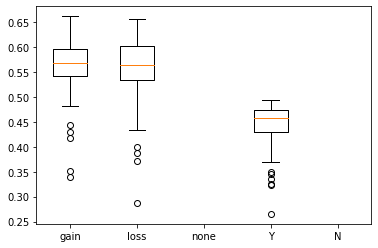

In [233]:
eval_prc(old,"pbSNP")

In [207]:
new = get_eval_data("GVATdb.novel_batch.csv","novel_batch")

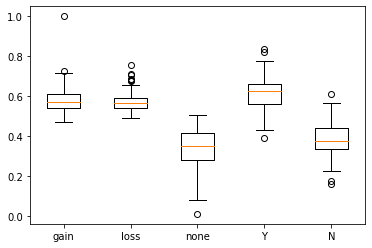

In [221]:
eval_auc(new,"pbSNP")

In [234]:
def get_binding_eval_data(file,folder):
    data = pd.read_csv(file)
    #True pbSNP
    data["binding"] = data["oligo_pval"]<0.05

    res = calc_results(folder,data["TF"].unique())
    data = data.merge(res, how='inner', on=["TF","snp"])
    #data = data.drop(columns=["experiment","oligo","rsid","oligo_auc","ref","alt","ref_auc","alt_auc","snp"])

    #Loss, Gain, None
    data["gain"] = data["preferred_allele"]=="Gain"
    data["loss"] = data["preferred_allele"]=="Loss"
    data["none"] = data["preferred_allele"]=="None"
    #Y,N
    data["Y"] = data["seq_binding"]=="Y"
    data["N"] = data["seq_binding"]=="N"

    #Only (P < 0.01) = True and non-pbSNPs (P > 0.5) = False
    #data = data[(data["pval"]<0.01) | (data["pval"]>0.5)]
    return data

In [235]:
new_binding = get_binding_eval_data("GVATdb.novel_batch.csv","novel_batch")

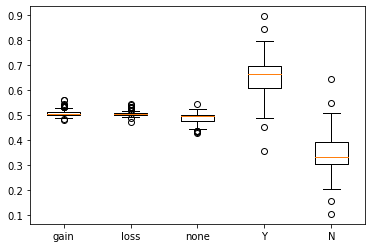

In [236]:
eval_auc(new_binding,"binding")

In [240]:
new_binding

TF                  snp  oligo_auc    oligo_pval       pbs  \
0       ATF2  chr14_105219467_A_G   8.824663  6.959774e-11  1.224176   
1       ATF2    chr2_29353111_A_G   3.219164  3.703025e-01  1.536405   
2       ATF2   chr11_18656062_G_C   2.545129  8.918721e-01 -0.837665   
3       ATF2   chr20_29612480_C_T   2.380765  9.999840e-01  3.993531   
4       ATF2   chr15_63414083_A_C   2.297799  7.791729e-01 -0.281098   
...      ...                  ...        ...           ...       ...   
191455  ZIC1   chr11_73499081_C_G   2.683985  2.003872e-01 -0.760521   
191456  ZIC1   chr16_81348764_C_T   1.755245  7.801769e-01  1.089755   
191457  ZIC1   chr1_100504162_C_T   3.699480  9.032282e-02  2.233823   
191458  ZIC1   chr17_48943852_G_A   3.431760  3.590786e-02  1.323970   
191459  ZIC1   chr9_126467202_C_T   3.035874  9.529562e-02 -1.967669   

            pval  binding  allele1_bind  allele2_bind seq_binding  \
0       0.200356     True      2.833040      2.452370           Y   
1       0.584366    False     -1.235670     -0.613007           N   
2       0.471546    False      1.175920      1.955280           Y   
3       0.038380    False     -1.124880     -1.700670           N   
4       0.927184    False      0.284352     -0.404943           N   
...          ...      ...           ...           ...         ...   
191455  0.722257    False     -1.764970     -1.447200           N   
191456  0.599654    False     -0.114661     -0.302010           Y   
191457  0.068383    False      0.388690     -0.806823           Y   
191458  0.515154     True     -0.869593     -1.261590           N   
191459  0.310571    False     -1.582090     -1.704100           N   

        deltaSVM_score preferred_allele   gain   loss  none      Y      N  
0            -2.105191             None  False  False  True   True  False  
1             3.472408             None  False  False  True  False   True  
2             4.344135             None  False  False  True   True  False  
3            -3.210161             None  False  False  True  False   True  
4            -3.907820             None  False  False  True  False   True  
...                ...              ...    ...    ...   ...    ...    ...  
191455        1.882638             None  False  False  True  False   True  
191456       -1.064589             None  False  False  True   True  False  
191457       -6.656768             None  False  False  True   True  False  
191458       -2.410140             None  False  False  True  False   True  
191459       -0.688380             None  False  False  True  False   True  

[191460 rows x 17 columns]

In [243]:
tf_auroc = {}
for tf in new_binding["TF"].unique():
        tf_auroc[tf] = (calc_auc(new_binding[new_binding["TF"]==tf],"binding","Y"))

{'whiskers': [<matplotlib.lines.Line2D at 0x1df22f1f340>,
 'caps': [<matplotlib.lines.Line2D at 0x1df22f1fa00>,
 'boxes': [<matplotlib.lines.Line2D at 0x1df24575fa0>],
 'medians': [<matplotlib.lines.Line2D at 0x1df22f1a0d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1df22f1a400>],
 'means': []}

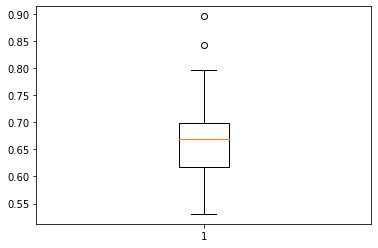

In [254]:
plt.boxplot(sorted(tf_auroc.values(),reverse = True)[:85])

In [6]:
scores = pd.read_csv("C:\Software\SynologyDrive\Master Thesis\Data\SELEX supplementary\The 94 high-confidence deltaSVM models predicted allelic binding of all common SNPs in the human genome.csv")

In [7]:
scores = scores.rename(columns={"tf": "TF"})

In [11]:
res = calc_results("novel_batch",scores["TF"].unique())
svm_scores = scores.merge(res, how='inner', on=["TF","snp"])

In [12]:
svm_scores

snp effect  gkm_score  deltasvm_score     TF  \
0      chr10_5654072_A_G   gain       1.63          -21.99   GCM2   
1     chr10_11220134_C_G   loss       1.48           37.86   GCM2   
2     chr10_70481214_G_A   gain       0.95          -30.51   GCM2   
3     chr10_80939219_G_C   gain       0.61          -22.68   GCM2   
4     chr10_82119203_C_T   gain       3.42          -18.27   GCM2   
...                  ...    ...        ...             ...    ...   
3982   chr8_97486281_G_A   gain       3.01          -25.91  CREB1   
3983  chr8_119006456_G_A   gain       2.55          -27.74  CREB1   
3984   chr9_33001665_G_A   gain       4.68          -24.95  CREB1   
3985   chr9_97671914_G_A   gain       4.93          -26.03  CREB1   
3986  chr9_134573714_C_T   gain       1.83          -23.13  CREB1   

      allele1_bind  allele2_bind seq_binding  deltaSVM_score preferred_allele  
0         1.628240     -0.381815           Y      -21.988196             Gain  
1        -2.255490      1.479510           Y       37.856881             Loss  
2         0.948123     -2.036110           Y      -30.506103             Gain  
3         0.609157     -1.619490           Y      -22.680571             Gain  
4         3.418870      1.606250           Y      -18.273130             Gain  
...            ...           ...         ...             ...              ...  
3982      3.011230      0.442249           Y      -25.913538             Gain  
3983      2.547630     -0.090014           Y      -27.736594             Gain  
3984      4.682430      2.060730           Y      -24.948851             Gain  
3985      4.932150      2.560190           Y      -26.029669             Gain  
3986      1.830770     -0.624910           Y      -23.131393             Gain  

[3987 rows x 10 columns]

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

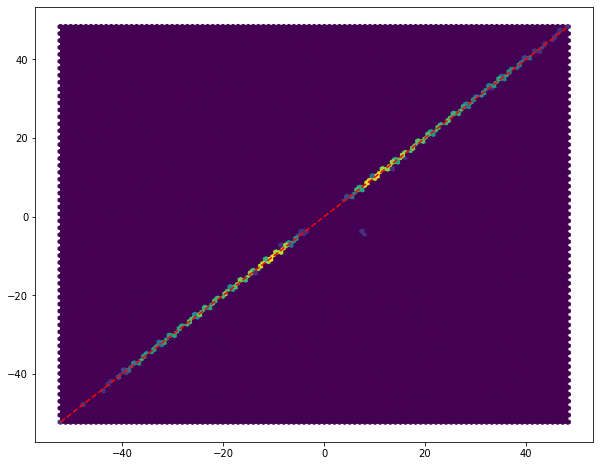

In [15]:
pl.his_plot(svm_scores["deltasvm_score"], svm_scores["deltaSVM_score"])